The first code block calculates proportion of the total image is made up by one boudning box. For cowbird, where multiple bboxes exist within single image, this means the proportion of each bbox is calculated individually

In [ ]:

import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Load the data from the JSON files
root = "/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/Bird_datasets_merged"
train_file_path = f"{root}/annotations/train.json"
test_file_path = f"{root}/annotations/test.json"

with open(train_file_path, 'r') as train_file:
    train_data = json.load(train_file)

with open(test_file_path, 'r') as test_file:
    test_data = json.load(test_file)


#Currently for cowbird it takes proportion of one bbox out of the entire image, not the sum of all bounding boxes within a single image - see second codeblock for this
def extract_bbox_proportions(data, dataset_name=None, all=True):
    proportions = {}
    for annotation in data['annotations']:
        image_id = annotation['image_id']
        bbox = annotation['bbox']
        image = next(img for img in data['images'] if img['id'] == image_id)
        if image['source_dataset']:
            dataset = image['source_dataset']
        image_size = image['width'] * image['height']
        
        # Set the bbox_size calculation based on dataset
        if dataset == "cowbird":
            # bbox = [x1, y1, width, height]
            bbox_size = bbox[2] * bbox[3]
        else:
            # bbox = [x1, y1, x2, y2]
            bbox_size = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
        
        proportion = bbox_size / image_size
        if all: 
            if dataset not in proportions:
                proportions[dataset] = []
            proportions[dataset].append(proportion)
        else:
            if dataset_name not in proportions:
                proportions[dataset_name] = []
            proportions[dataset_name].append(proportion)
    return proportions

# Extract bounding box proportions for train and test data
train_proportions_by_dataset = extract_bbox_proportions(train_data)
test_proportions_by_dataset = extract_bbox_proportions(test_data)

# # Print the lengths of all datasets in train_proportions_by_dataset
# for dataset in train_proportions_by_dataset:
#     print(f"Dataset: {dataset}, Length: {len(train_proportions_by_dataset[dataset])}")

# Combine train and test proportions
combined_proportions_by_dataset = {}
for dataset in set(train_proportions_by_dataset.keys()).union(test_proportions_by_dataset.keys()):
    combined_proportions_by_dataset[dataset] = train_proportions_by_dataset.get(dataset, []) + test_proportions_by_dataset.get(dataset, [])

# Plot histograms for each dataset in a grid-like format
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for ax, (dataset, proportions) in zip(axes, combined_proportions_by_dataset.items()):
    ax.hist(proportions, bins=30, edgecolor='black')
    ax.set_title(f'Histogram of Bounding Box Proportions in {dataset}')
    ax.set_xlabel('Proportion of Image Size')
    ax.set_ylabel('Frequency')
    ax.ticklabel_format(style='plain', axis='x')  # Disable scientific notation on x-axis
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))
    plt.setp(ax.get_xticklabels(), rotation=45)

# Hide any unused subplots
for i in range(len(combined_proportions_by_dataset), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


This second code block calculates the proportion of the image that is made up of the sum of all bbox areas within the image.

Dataset: tiny_nabirds, Length: 100
Dataset: cowbird, Length: 31
Dataset: CUB_200_2011, Length: 100


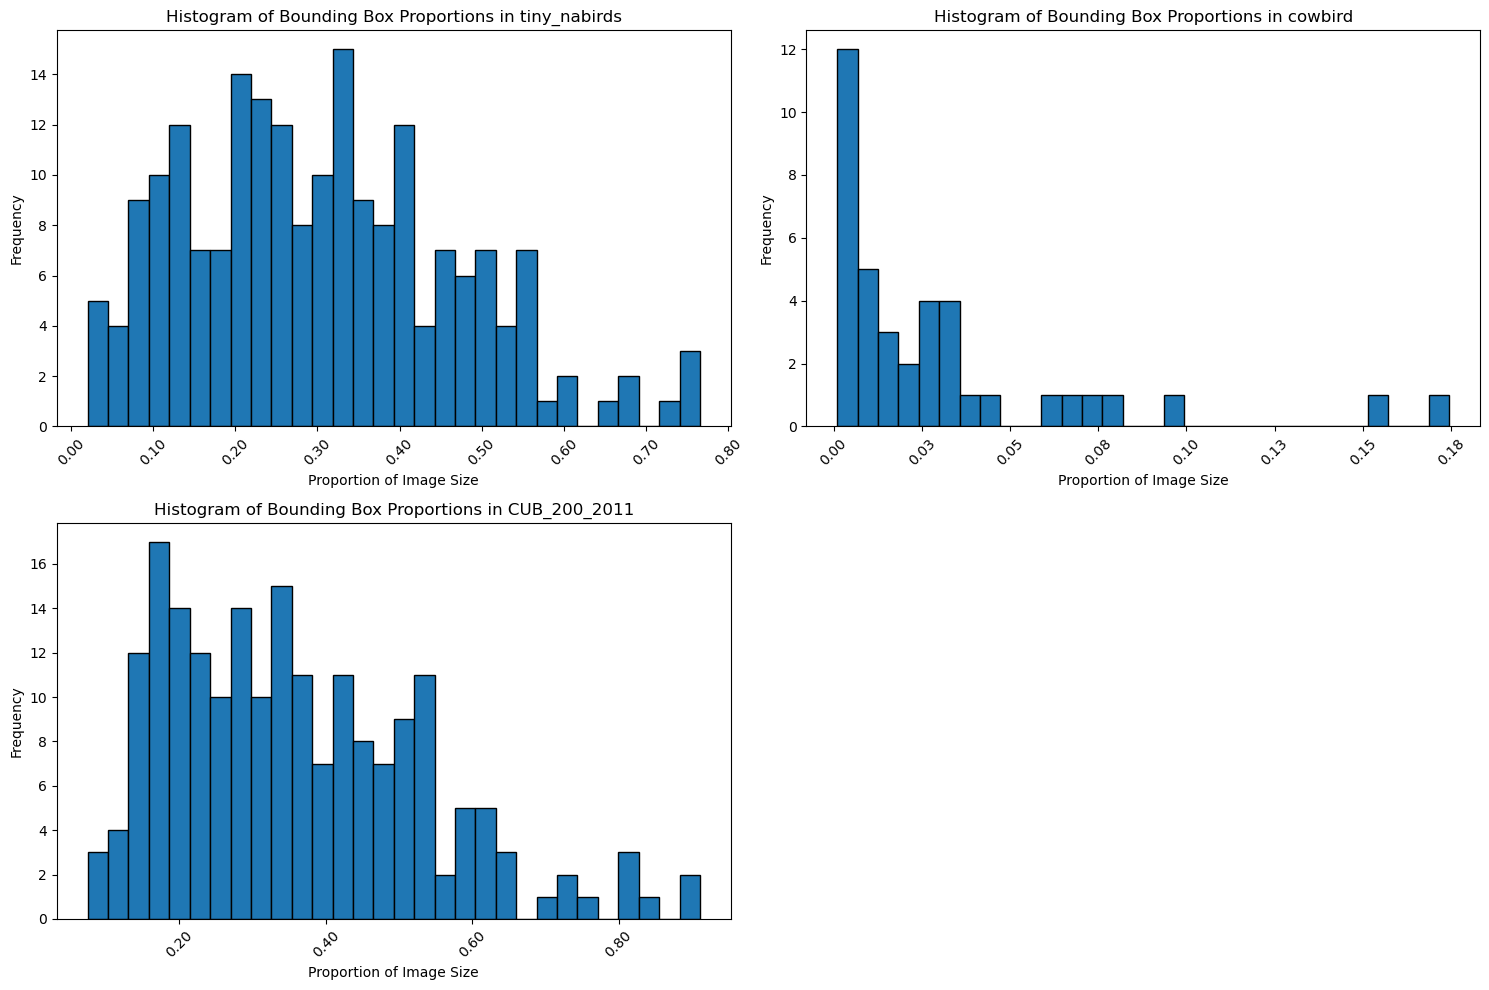

In [14]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Load the data from the JSON files
root = "/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/Bird_datasets_merged"
train_file_path = f"{root}/annotations/train.json"
test_file_path = f"{root}/annotations/test.json"

with open(train_file_path, 'r') as train_file:
    train_data = json.load(train_file)

with open(test_file_path, 'r') as test_file:
    test_data = json.load(test_file)

# Function to calculate proportions of bbox area sum of out parent image size
def sum_bbox_proportions(data, dataset_name=None):
    proportions_by_dataset = {}
    bbox_sums_by_image = {}

    for annotation in data['annotations']:
        image_id = annotation['image_id']
        bbox = annotation['bbox']
        image = next(img for img in data['images'] if img['id'] == image_id)
        if image['source_dataset']:
            dataset = image['source_dataset']
        else: dataset = dataset_name
        image_size = image['width'] * image['height']

        # Set the bbox_size calculation based on dataset
        if dataset == "cowbird":
            # bbox = [x1, y1, width, height]
            bbox_size = bbox[2] * bbox[3]
        else:
            # bbox = [x1, y1, x2, y2]
            bbox_size = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

        if image_id not in bbox_sums_by_image:
            bbox_sums_by_image[image_id] = {'sum_bbox_size': 0, 'image_size': image_size, 'dataset': dataset}

        bbox_sums_by_image[image_id]['sum_bbox_size'] += bbox_size

    # Now calculate the proportions for each dataset
    for image_id, bbox_info in bbox_sums_by_image.items():
        proportion = bbox_info['sum_bbox_size'] / bbox_info['image_size']
        dataset = bbox_info['dataset']

        if dataset not in proportions_by_dataset:
            proportions_by_dataset[dataset] = []

        proportions_by_dataset[dataset].append(proportion)

    return proportions_by_dataset

# Extract bounding box proportions for train and test data
train_proportions_by_dataset = extract_bbox_proportions(train_data)
test_proportions_by_dataset = extract_bbox_proportions(test_data)

# Print the lengths of all datasets in train_proportions_by_dataset
# for dataset in train_proportions_by_dataset:
#     print(f"Dataset: {dataset}, Length: {len(train_proportions_by_dataset[dataset])}")


# Combine train and test proportions
combined_proportions_by_dataset = {}
for dataset in set(train_proportions_by_dataset.keys()).union(test_proportions_by_dataset.keys()):
    combined_proportions_by_dataset[dataset] = train_proportions_by_dataset.get(dataset, []) + test_proportions_by_dataset.get(dataset, [])

# Plot histograms for each dataset in a grid-like format
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for ax, (dataset, proportions) in zip(axes, combined_proportions_by_dataset.items()):
    ax.hist(proportions, bins=30, edgecolor='black')
    ax.set_title(f'Histogram of Bounding Box Proportions in {dataset}')
    ax.set_xlabel('Proportion of Image Size')
    ax.set_ylabel('Frequency')
    ax.ticklabel_format(style='plain', axis='x')  # Disable scientific notation on x-axis
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))
    plt.setp(ax.get_xticklabels(), rotation=45)

# Hide any unused subplots
for i in range(len(combined_proportions_by_dataset), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


Alternatively, #TODO segmentation masks directly reflecting bird size (not just bbox) exist only for cowbird dataset - consider implementing the code using segmentation mask to more correctly reflect bird size